In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
import time


from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

data = pd.read_csv("WellA_complete.csv")

data.head()

,MD,FACIES,CNL,CPOR,DENS,GR,KAH,LL9D,NEU,RT,SONI,CAT,LOGKAH
0,10277.0,1,11.889,6.0,2.663,74.694,0.01,9.805,0.11889,9.51109,73.251,1,-2.000000
1,10278.5,1,16.377,6.8,2.556,103.176,0.03,4.258,0.16377,3.44852,84.524,2,-1.522879
2,10279.0,1,19.212,3.6,2.521,108.483,0.01,4.106,0.19212,3.58963,85.573,1,-2.000000
3,10280.0,1,18.975,6.3,2.532,119.589,0.07,4.578,0.18975,3.56376,87.474,2,-1.154902
4,10282.0,1,19.865,8.6,2.542,116.502,0.28,4.106,0.19865,3.46187,83.729,1,-0.552842


In [2]:
data.describe()

,MD,FACIES,CNL,CPOR,DENS,GR,KAH,LL9D,NEU,RT,SONI,CAT,LOGKAH
count,528.000000,528.000000,528.000000,528.000000,528.000000,528.00000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000
mean,10612.445076,2.172348,20.747634,22.621780,2.250163,96.94150,733.119678,21.149362,0.207476,28.350367,85.819536,1.500000,2.348025
std,200.421668,0.748580,2.316153,5.623986,0.108985,16.09447,801.905129,19.460699,0.023162,25.721062,6.986286,0.500474,1.067174
min,10277.000000,1.000000,11.889000,3.600000,2.095000,68.60600,0.010000,0.291000,0.118890,0.197760,68.012000,1.000000,-2.000000
25%,10484.875000,2.000000,19.485000,20.075000,2.176750,85.85200,110.000000,6.762250,0.194850,9.337110,80.298750,1.000000,2.041393
50%,10612.500000,2.000000,20.920000,24.300000,2.215000,93.41200,455.000000,16.589000,0.209200,23.865065,87.416500,1.500000,2.657985
75%,10738.250000,3.000000,22.225000,26.800000,2.304000,102.71025,1100.000000,29.934500,0.222250,39.948510,90.951250,2.000000,3.041393
max,11016.500000,3.000000,25.810000,33.300000,2.663000,190.74700,4500.000000,103.237000,0.258100,158.965000,99.050000,2.000000,3.653213


We can see that every column has the same count value, hence there is no missing data. The min and max values can also point to potential outliers/errors. In this case, the data looks okay

Next, we define a color map for the facies and make a log plot

In [3]:
facies_labels = ["Facies_1", "Facies_2", "Facies_3"]
facies_colors = ['#F5B041','#2E86C1', '#196F3D']
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

In [4]:
def make_facies_log_plot(logs, facies_colors):

    #make sure logs are sorted by depth
    logs = logs.sort_values(by='MD')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.MD.min(); zbot=logs.MD.max()
    
    cluster=np.repeat(np.expand_dims(data['FACIES'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(8, 12))
    ax[0].plot(logs.CNL, logs.MD, '-g')
    ax[1].plot(logs.DENS, logs.MD, '-')
    ax[2].plot(logs.LL9D, logs.MD, '-', color='0.5')
    ax[3].plot(logs.SONI, logs.MD, '-', color='r')
    im = ax[4].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=3)
    
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((60*' ').join(['1', '2', '3']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("CNL")
    ax[0].set_xlim(logs.CNL.min(),logs.CNL.max())
    ax[1].set_xlabel("DENS")
    ax[1].set_xlim(logs.DENS.min(),logs.DENS.max())
    ax[2].set_xlabel("LL9D")
    ax[2].set_xlim(logs.LL9D.min(),logs.LL9D.max())
    ax[3].set_xlabel("SONI")
    ax[3].set_xlim(logs.SONI.min(),logs.SONI.max())
    ax[4].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([])
    ax[4].set_xticklabels([])

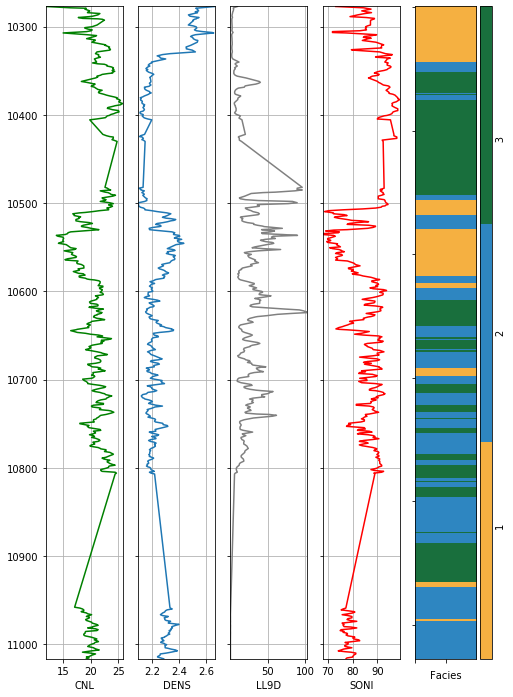

In [5]:
make_facies_log_plot(data, facies_colors)

We can now look at how the various facies are represented in the data set. We plot a histgram of the number of training examples for each facies class.

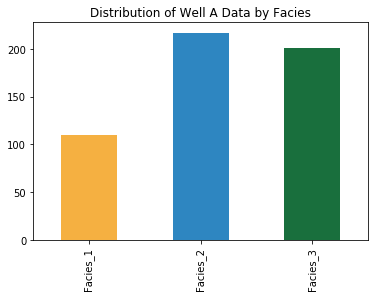

In [6]:
facies_counts = data["FACIES"].value_counts().sort_index()  
#Modify "in-place", the indices of facies_counts above 
facies_counts.index = facies_labels

facies_counts.plot(kind="bar", color=facies_colors, title='Distribution of Well A Data by Facies')


We can see that Facies 1 is represented the least in Well A's data while Facies 2 and Facies 3 have roughtly equal representations in the data

Next, we create a new column in the data which we will call "FaciesLabels"

In [7]:
def label_facies(row, labels):
    return labels[int(row["FACIES"] - 1)]

data.loc[:, "FaciesLabels"] = data.apply(lambda row: label_facies(row, facies_labels), axis=1)


Next, we create a crossplot of the dataset. Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type. This dataset contains 4 log variables and the predictor variable, LOGKAH, and scatter matrix can help to quickly visualize the variation between all the variables in the dataset. We use the Seaborn library to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies. The same colormap is used to represent the 3 facies. 

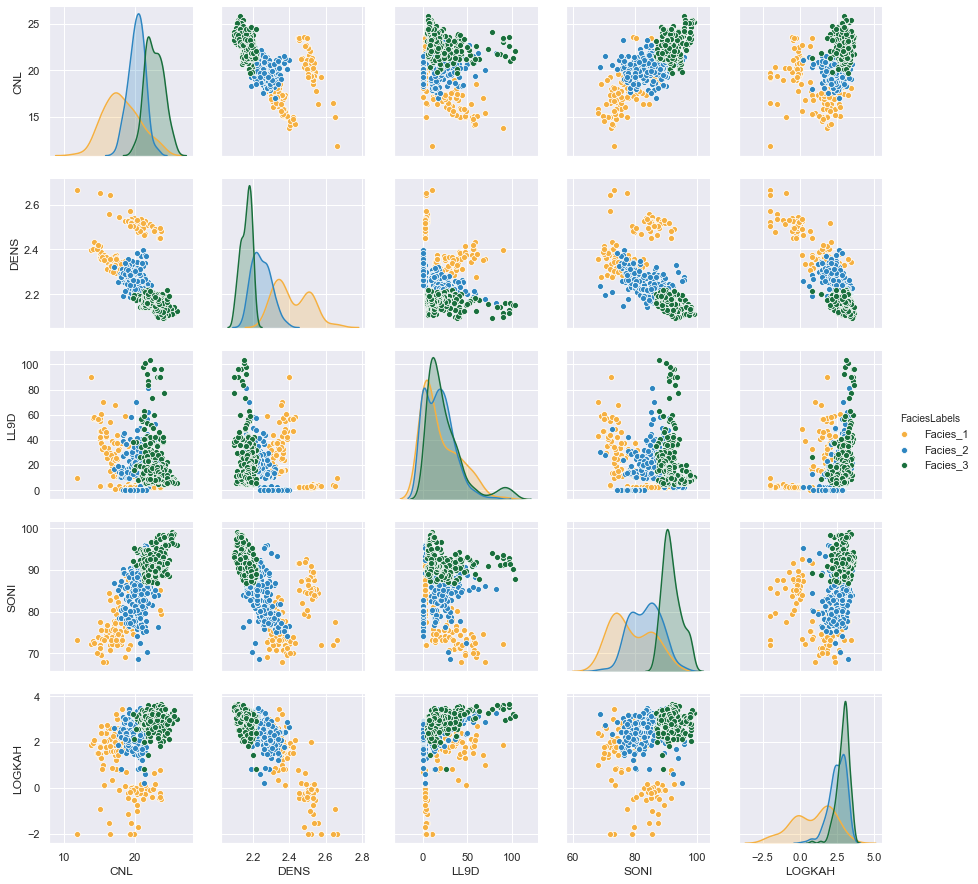

In [8]:
import seaborn as sns
sns.set() 
sns.pairplot(data[["CNL", "DENS", "LL9D", "SONI", "FaciesLabels", "LOGKAH"]], hue="FaciesLabels",
             palette=facies_color_map)

## Preprocessing the dataset

In [9]:
from sklearn.model_selection import train_test_split

y_strfy = data['FACIES'].values
y = data['LOGKAH']
X = data[["CNL", "DENS", "LL9D", "SONI"]]
indices = range(len(y_strfy))
test_sizes = [0.9, 0.8, 0.7, 0.6, 0]



X_train, X_test, strfy_y_train, strfy_y_test, indices_train, indices_test = train_test_split(X, y_strfy, indices, test_size=0.5, random_state=42, stratify=y_strfy)   
y_train = y.values[indices_train]
indices_2 = range(len(y_train))
y_test = y.values[indices_test]
md = data['MD'].values[indices_test] # md
md
True_k = data['LOGKAH'].values[indices_test] # TRUE K

In [10]:
X

,CNL,DENS,LL9D,SONI
0,11.889,2.663,9.805,73.251
1,16.377,2.556,4.258,84.524
2,19.212,2.521,4.106,85.573
3,18.975,2.532,4.578,87.474
4,19.865,2.542,4.106,83.729
...,...,...,...,...
523,20.194,2.257,0.302,80.415
524,19.721,2.239,0.302,80.150
525,19.249,2.239,0.302,80.150
526,19.721,2.262,0.302,77.787


In [11]:
y

0     -2.000000
1     -1.522879
2     -2.000000
3     -1.154902
4     -0.552842
         ...   
523    2.579784
524    2.397940
525    2.838849
526    2.230449
527    2.799341
Name: LOGKAH, Length: 528, dtype: float64

Next, we standardize the training data.

Scikit includes a preprocessing module that can 'standardize' the data (giving each variable zero mean and unit variance). Many machine learning algorithms assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance). The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier. The StandardScalar class can be fit to the training set, and later used to standardize any test data.

The feature training and test data as well as the feature test data are all standardized. We note that it is crucial to fit the feature test data according to the same scale used to standardize the feature training data

In [12]:
#from sklearn.preprocessing import StandardScaler

#sc_x = StandardScaler().fit(X_train)
#X_train_std = sc_x.transform(X_train)
#X_test_std = sc_x.transform(X_test)

#sc_y = StandardScaler().fit(y_train.reshape(-1, 1))
#y_train_std = sc_y.transform(y_train.reshape(-1, 1)).flatten()

## Define a function for the various regression functions

In [13]:
def regression(regressor):
    """Choose one of the following regression tools: SVR_RBF, SVR_Linear, Kernel_Ridge_Regressor, Multiple_Linear_Regressor, 
    Decision_Tree_Regressor or Random_Forest_Regressor"""
    for testing_size in test_sizes:
        if testing_size == 0:
            X_train_new = X_train
            y_train_new = y_train
        else: 
            X_train_new, Xsplit_test, strfy_y_train_new, strfy_y_test_new, indices_train, indices_test = train_test_split(X_train, strfy_y_train, indices_2, test_size=testing_size, random_state=1, stratify=strfy_y_train)   
            y_train_new = y_train[indices_train]

        if regressor == "Multiple_Linear_Regressor":
            time_start = time.clock()
            reg = LinearRegression()
            reg.fit(X_train_new, y_train_new)
            predicted_values = reg.predict(X_test)
            len(predicted_values)
            time_elapsed = (time.clock() - time_start)
       
                               
           
            MAE  = mean_absolute_error(y_test, predicted_values)
            RMSE = sqrt(mean_squared_error(y_test, predicted_values))
            r2score = r2_score(y_test, predicted_values) 
            
        if regressor =="Decision_Tree_Regressor":
            time_start = time.clock()
            reg = DecisionTreeRegressor(random_state=0)
            reg.fit(X_train_new, y_train_new)
            predicted_values = reg.predict(X_test)
            time_elapsed = (time.clock() - time_start)
                        
            
            MAE  = mean_absolute_error(y_test, predicted_values)
            RMSE = sqrt(mean_squared_error(y_test, predicted_values))
            r2score = r2_score(y_test, predicted_values)             
            
        if regressor == "Random_Forest_Regressor":
            time_start = time.clock()
#            reg = RandomForestRegressor(random_state=0) 
            parameters = {"n_estimators": [10, 20, 50, 100, 300, 500]}
            reg = GridSearchCV(RandomForestRegressor(random_state=0), param_grid=parameters, cv=10)
            reg.fit(X_train_new, y_train_new)
            predicted_values = reg.predict(X_test)
            time_elapsed = (time.clock() - time_start)
  
                               
           
            MAE  = mean_absolute_error(y_test, predicted_values)
            RMSE = sqrt(mean_squared_error(y_test, predicted_values))
            r2score = r2_score(y_test, predicted_values)             
            
        if regressor == "SVR_RBF": 
            time_start = time.clock()
            sc_x = StandardScaler().fit(X_train_new)
            X_train_std = sc_x.transform(X_train_new)
            X_test_std = sc_x.transform(X_test)
          
            sc_y = StandardScaler().fit(y_train_new.reshape(-1, 1))
            y_train_std = sc_y.transform(y_train_new.reshape(-1, 1)).flatten()                 
        
#            reg.fit(X_train_std, y_train_std)

            #Specify the parameter ranges for the selected parameters to tune 
            parameters = {"C": [1e-1, 1e0, 1e1, 1e2, 1e3],
                                           "gamma": [1e-2, 1e-1, 0.2, 0.25, 1e0, 1e1, 1e2],
                                           "epsilon": [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]}
            
            #Search for the best parameter using r2 score and cross validation on the training set
            reg = GridSearchCV(SVR(kernel='rbf'), param_grid=parameters, cv=10)
            
            reg.fit(X_train_std, y_train_std)
            predicted_values_std = reg.predict(X_test_std)
            
            predicted_values = sc_y.inverse_transform(predicted_values_std)
            time_elapsed = (time.clock() - time_start)
   
                           
          
            MAE  = mean_absolute_error(y_test, predicted_values)
            RMSE = sqrt(mean_squared_error(y_test, predicted_values))
            r2score = r2_score(y_test, predicted_values)
            
            
        if regressor == "SVR_Linear":
            time_start = time.clock()
            sc_x = StandardScaler().fit(X_train_new)
            X_train_std = sc_x.transform(X_train_new)
            X_test_std = sc_x.transform(X_test)
          
            sc_y = StandardScaler().fit(y_train_new.reshape(-1, 1))
            y_train_std = sc_y.transform(y_train_new.reshape(-1, 1)).flatten()                 
        

            #Specify the parameter ranges for the selected parameters to tune 
            parameters = {"C": [1e-1, 1e0, 1e1, 1e2, 1e3], "epsilon": [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]}
            
            #Search for the best parameter using r2 score and cross validation on the training set
            reg = GridSearchCV(SVR(kernel='linear'), param_grid=parameters, cv=10)
            
            reg.fit(X_train_std, y_train_std)
            predicted_values_std = reg.predict(X_test_std)
            
            predicted_values = sc_y.inverse_transform(predicted_values_std)
            time_elapsed = (time.clock() - time_start)

            MAE  = mean_absolute_error(y_test, predicted_values)
            RMSE = sqrt(mean_squared_error(y_test, predicted_values))
            r2score = r2_score(y_test, predicted_values)

     
        if regressor == "Kernel_Ridge_Regressor":
            time_start = time.clock()

            sc_x = StandardScaler().fit(X_train_new)
            X_train_std = sc_x.transform(X_train_new)
            X_test_std = sc_x.transform(X_test)
          
            sc_y = StandardScaler().fit(y_train_new.reshape(-1, 1))
            y_train_std = sc_y.transform(y_train_new.reshape(-1, 1)).flatten()                 
            
            
            reg = KernelRidge()
            reg.fit(X_train_std, y_train_std)
            predicted_values_std = reg.predict(X_test_std)
         
            predicted_values = sc_y.inverse_transform(predicted_values_std)
            time_elapsed = (time.clock() - time_start)
  
                       
            MAE  = mean_absolute_error(y_test, predicted_values)
            RMSE = sqrt(mean_squared_error(y_test, predicted_values))            
            r2score = r2_score(y_test, predicted_values)
        

        Results = {'Training Size': ['{:.0f} %'. format((1 - testing_size)*50)],'r2score':[r2score],'RSME': [RMSE] , 
                            'MAE': [MAE],'ET': [ time_elapsed]}

        df = pd.DataFrame(Results,columns= ['Training Size','r2score', 'RSME', 'MAE', 'ET'])

        print (df)

            #df.to_csv("S_train_75%.csv")
           

# View r2 scores

## Multiple Linear Regression results

In [14]:
regression(regressor="Multiple_Linear_Regressor")


  Training Size   r2score      RSME       MAE        ET
0           5 %  0.626651  0.610601  0.470311  0.031275
  Training Size   r2score      RSME       MAE        ET
0          10 %  0.652727  0.588892  0.463052  0.005105
  Training Size   r2score      RSME      MAE        ET
0          15 %  0.719302  0.529444  0.40632  0.009144
  Training Size   r2score      RSME       MAE        ET
0          20 %  0.726302  0.522801  0.396611  0.012228
  Training Size   r2score      RSME       MAE        ET
0          50 %  0.740946  0.508622  0.380026  0.005395


C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: Depreca

## SVR with Radial Basis Kernel results

In [15]:
regression(regressor="SVR_RBF")

C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


  Training Size   r2score     RSME       MAE        ET
0           5 %  0.699094  0.54817  0.408166  3.966852


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


  Training Size   r2score      RSME       MAE        ET
0          10 %  0.716297  0.532271  0.394467  5.120586


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


  Training Size   r2score      RSME       MAE        ET
0          15 %  0.755654  0.493973  0.355999  7.204437


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


  Training Size   r2score      RSME       MAE        ET
0          20 %  0.694998  0.551888  0.387763  8.909666
  Training Size   r2score      RSME       MAE         ET
0          50 %  0.761872  0.487647  0.339843  44.039862


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


## SVR with Linear Kernel results

In [16]:
regression(regressor="SVR_Linear")

C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


  Training Size   r2score      RSME       MAE       ET
0           5 %  0.735642  0.513802  0.385949  6.11729


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


  Training Size   r2score      RSME       MAE         ET
0          10 %  0.718003  0.530668  0.398571  10.386857


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


  Training Size   r2score      RSME      MAE         ET
0          15 %  0.729691  0.519554  0.38455  17.673114


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


  Training Size   r2score      RSME       MAE         ET
0          20 %  0.732418  0.516927  0.378789  19.941913
  Training Size   r2score      RSME       MAE        ET
0          50 %  0.734258  0.515146  0.381986  69.77617


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


## Kernel Ridge Regressor results

In [17]:
regression(regressor="Kernel_Ridge_Regressor")

C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: DeprecationWarning: time.clock has bee

  Training Size   r2score      RSME       MAE        ET
0           5 %  0.613585  0.621194  0.478351  0.054973
  Training Size   r2score      RSME       MAE        ET
0          10 %  0.647783  0.593069  0.466468  0.008798
  Training Size   r2score      RSME       MAE        ET
0          15 %  0.716379  0.532193  0.407693  0.012577
  Training Size  r2score      RSME       MAE      ET
0          20 %  0.72465  0.524376  0.397021  0.0105


C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


  Training Size   r2score      RSME       MAE        ET
0          50 %  0.740419  0.509139  0.380265  0.033387


## Decision Tree Regressor

In [18]:
regression(regressor="Decision_Tree_Regressor")

C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: time.clock has been dep

  Training Size   r2score      RSME       MAE        ET
0           5 %  0.278318  0.848933  0.680846  0.013358
  Training Size   r2score      RSME       MAE        ET
0          10 %  0.538277  0.679033  0.517359  0.010135
  Training Size   r2score      RSME       MAE        ET
0          15 %  0.470578  0.727112  0.519515  0.005362
  Training Size   r2score      RSME       MAE        ET
0          20 %  0.505949  0.702402  0.517072  0.004927
  Training Size  r2score      RSME       MAE        ET
0          50 %    0.618  0.617635  0.458015  0.006527


## Random Forest Regressor results

In [19]:
regression(regressor="Random_Forest_Regressor")

C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


  Training Size   r2score      RSME       MAE         ET
0           5 %  0.476574  0.722982  0.561624  10.037317


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


  Training Size   r2score      RSME       MAE        ET
0          10 %  0.672682  0.571723  0.429263  9.483777


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


  Training Size   r2score     RSME       MAE         ET
0          15 %  0.705992  0.54185  0.403539  10.046591


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


  Training Size   r2score      RSME       MAE         ET
0          20 %  0.741024  0.508546  0.381027  10.915391


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


  Training Size   r2score      RSME      MAE         ET
0          50 %  0.749571  0.500083  0.36121  15.632341


C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
